**Корректность проверена на Python 3.7:**
+ pandas 0.23.0
+ numpy 1.14.5
+ scipy 1.1.0
+ statsmodels 0.9.0

# Непараметрические криетрии

  Критерий | Одновыборочный | Двухвыборочный | Двухвыборочный (связанные выборки)  
  ------------- | -------------|
  **Знаков**  | $\times$ | | $\times$ 
  **Ранговый** | $\times$  | $\times$ | $\times$  
  **Перестановочный** | $\times$  | $\times$ | $\times$ 

## Недвижимость в Сиэттле

Имеются данные о продажной стоимости недвижимости в Сиэтле для 50 сделок в 2001 году и 50 в 2002. Изменились ли в среднем цены?

In [10]:
import numpy as np
import pandas as pd
import itertools

from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint
from statsmodels.stats.weightstats import *

In [11]:
import scipy
import statsmodels
print(np.__version__)
print(pd.__version__)
print(scipy.__version__)
print(statsmodels.__version__)

1.16.2
0.24.2
1.2.1
0.9.0


In [12]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Загрузка данных

In [14]:
seattle_data = pd.read_csv('seattle.txt', sep = '\t', header = 0)

In [15]:
seattle_data.shape

(100, 2)

In [16]:
seattle_data.head()

,Price,Year
0,142.0,2002
1,232.0,2002
2,132.5,2002
3,200.0,2002
4,362.0,2002


In [17]:
price2001 = seattle_data[seattle_data['Year']  == 2001].Price
price2002 = seattle_data[seattle_data['Year']  == 2002].Price

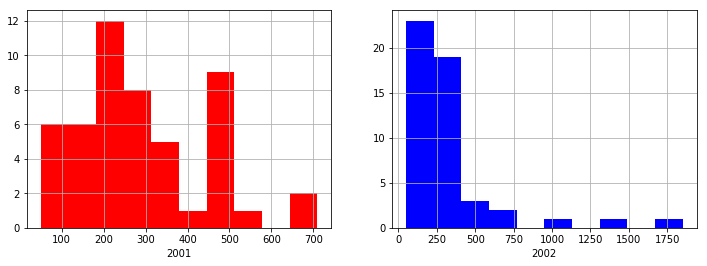

In [18]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(price2001, color = 'r')
pylab.xlabel('2001')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(price2002, color = 'b')
pylab.xlabel('2002')

pylab.show()

## Двухвыборочные критерии для независимых выборок

In [19]:
print('95%% confidence interval for the mean: [%f, %f]' % zconfint(price2001))

95% confidence interval for the mean: [245.193581, 332.659499]


In [20]:
print('95%% confidence interval for the mean: [%f, %f]' % zconfint(price2002))

95% confidence interval for the mean: [241.437946, 417.076334]


Пересечение довольно сильное, поэтому нам опять же сложно сделать выводы о том, изменились ли цены или нет. Единственное, что мы видим, что правый интервал доверительного интервала для 2002 года сильно правее. Поэтому мы можем предположить, что какие-то изменения были.

### Ранговый критерий Манна-Уитни

 вероятность того, что значение из первой выборки будет больше, чем значение из второй выборки, равна вероятности того, что значение из второй выборки будет больше, чем значение из первой выборки.

кривожопсть ноут. хз зеровый криетерий) 

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [22]:
stats.mannwhitneyu(price2001, price2002)

MannwhitneyuResult(statistic=1204.5, pvalue=0.3781936337850874)

### Перестановочный критерий

Таким образом, нулевая гипотеза состоит в том, что функции распределения для первой и второй выборки одинаковы. Они совпадают. Альтернатива следующая: функция распределения одной выборки получается сдвигом на некоторую дельту из функции распределения на другой выборке.

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [28]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [29]:
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [30]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), list(filter(lambda i: i not in index, range(n)))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

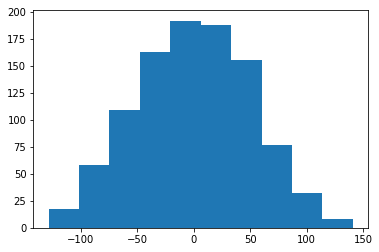

In [31]:
pylab.hist(permutation_zero_dist_ind(price2001, price2002, max_combinations = 1000))
pylab.show()

In [32]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [33]:
print("p-value: %f" % permutation_test(price2001, price2002, max_permutations = 10000))

p-value: 0.439000


In [34]:
print("p-value: %f" % permutation_test(price2001, price2002, max_permutations = 50000))

p-value: 0.445240


В ходе исследования влияния лесозаготовки на биоразнообразие лесов острова Борнео собраны данные о количестве видов деревьев в 12 лесах, где вырубка не ведётся:

22, 22, 15, 13, 19, 19, 18, 20, 21, 13, 13, 15

и в 9 лесах, где идёт вырубка:

17, 18, 18, 15, 12, 4, 14, 15, 10

Проверьте гипотезу о равенстве среднего количества видов в двух типах лесов против односторонней альтернативы о снижении биоразнообразия в вырубаемых лесах. Используйте ранговый критерий. Чему равен достигаемый уровень значимости? Округлите до четырёх знаков после десятичной точки.

In [35]:
les1=np.array([22, 22, 15, 13, 19, 19, 18, 20, 21, 13, 13, 15])
les2=np.array([17, 18, 18, 15, 12, 4, 14, 15, 10])

In [43]:
les1.mean(), les2.mean()

(17.5, 13.666666666666666)

In [40]:
stats.mannwhitneyu(les1, les2,alternative='greater')

MannwhitneyuResult(statistic=81.0, pvalue=0.02900499272087373)

Видовое разнообразие уменьшилось! 

**28 января 1986 года космический шаттл "Челленджер" взорвался при взлёте. Семь астронавтов, находившихся на борту, погибли. В ходе расследования причин катастрофы основной версией была неполадка с резиновыми уплотнительными кольцами в соединении с ракетными ускорителями. Для 23 предшествовавших катастрофе полётов "Челленджера" известны температура воздуха и появление повреждений хотя бы у одного из уплотнительных колец.**



С помощью бутстрепа постройте 95% доверительный интервал для разности средних температур воздуха при запусках, когда уплотнительные кольца повреждались, и запусках, когда повреждений не было. Чему равна его ближайшая к нулю граница? Округлите до четырёх знаков после запятой.

Чтобы получить в точности такой же доверительный интервал, как у нас:

установите random seed = 0 перед первым вызовом функции get_bootstrap_samples, один раз сделайте по 1000 псевдовыборок из каждой выборки.

In [72]:
chal=pd.read_csv('challenger.txt', sep = '\t')

In [73]:
chal.head()

,Unnamed: 0,Temperature,Incident
0,Apr12.81,18.9,0
1,Nov12.81,21.1,1
2,Mar22.82,20.6,0
3,Nov11.82,20.0,0
4,Apr04.83,19.4,0


In [77]:
chal1=chal[chal['Incident'] == 1].drop(['Unnamed: 0'],axis=1)

In [78]:
chal0=chal[chal['Incident'] == 0].drop(['Unnamed: 0'],axis=1)

In [106]:
chal1

,Temperature,Incident
1,21.1,1
8,13.9,1
9,17.2,1
10,21.1,1
13,11.7,1
20,23.9,1
22,14.4,1


In [107]:
chal0

,Temperature,Incident
0,18.9,0
2,20.6,0
3,20.0,0
4,19.4,0
5,22.2,0
6,22.8,0
7,21.1,0
11,25.6,0
12,19.4,0
14,19.4,0


In [80]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data))) 
    # генерим 1000 выборок размера исходных данных из индексов от 0 до лен дата
    samples = data[indices] 
    # получаем эти индексы, дальше получаем выборки, применяя эти индексы набору данных для отд. региона, и возвращаем выборки.
    return samples

In [81]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)]) 
    # 95% интевар. слева 2,5 и справа 97,5 квантили
    return boundaries
# Функция очень простая, передаём ей статистики, передаём ей α, а дальше берём наши статистики и упорядочиваем их
# по возрастанию, и говорим, что мы просто отрезаем слева и справа по кусочку равному α / 2 (слева) и (1 − α) / 2 (справа). 
#Давайте начнём с того, что получим независимые интервальные оценки медианы для клиентов двух типов. 

In [111]:
stat_intervals(challenger_broken_bs_mean - challenger_not_broken_bs_mean, 0.05)

array([-8.06457589, -1.45040179])

In [125]:
np.random.seed(0)

broke = list(map(np.mean, get_bootstrap_samples(chal1['Temperature'].values, 1000)))
unbroke = list(map(np.mean, get_bootstrap_samples(chal0['Temperature'].values, 1000)))

stat_intervals(broke, 0.05), stat_intervals(unbroke, 0.05)

(array([14.61428571, 20.71607143]), array([21.14359375, 23.55046875]))

In [126]:
mean_1=np.array(broke)

In [127]:
mean_2=np.array(unbroke)

In [128]:
stat_intervals((mean_1-mean_2), 0.05)

array([-8.06457589, -1.45040179])

In [129]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(broke, unbroke)))

In [132]:
stat_intervals(delta_median_scores, 0.05)

array([1.45040179, 8.06457589])